In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm

#Custom Classes
from prep import Preparation
from gru_decoder import GRU_Decoder
from gru_encoder import GRU_Encoder
from cnn_encoder import CNN_Encoder

In [2]:
prep = Preparation()

In [3]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [4]:
with open("../dataset/best_captions.json", "r") as jf:
    data = json.loads(jf.read())
    
target_data = data['target_paths']
distractor_data = data['distractor_paths']
caption_data = data['best_captions']

In [5]:
edited_caption_data = []
for i in range(len(caption_data)):
    edited_caption_data.append(f'<start> {caption_data[i]} <end>')

In [6]:
#Split into train, val, and test set.
val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_data[:val_slice_index], target_data[val_slice_index:test_slice_index], target_data[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_data[:val_slice_index], distractor_data[val_slice_index:test_slice_index], distractor_data[test_slice_index:]

captions_train, captions_val, captions_test = edited_caption_data[:val_slice_index], edited_caption_data[val_slice_index:test_slice_index], edited_caption_data[test_slice_index:]


<start> He has a goatee. <end>


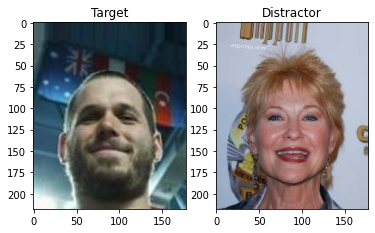

In [7]:
img_A = mpimg.imread(f"../dataset/prep_data/{targ_name_test[0]}.jpg")
img_B = mpimg.imread(f"../dataset/prep_data/{dis_name_test[0]}.jpg")
print(captions_test[0])
# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text("Target")
ax[0].imshow(img_A)
ax[1].title.set_text("Distractor")
ax[1].imshow(img_B)

In [9]:
#Tokenize the captions
top_v = 45
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions_train)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(captions_train)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = 5

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim_s = 1024
embedding_dim_l = 512
units = 512
vocab_size = top_v + 1
num_steps = len(targ_name_train) // BATCH_SIZE

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train, cap_vector))
dataset = dataset.map(lambda item1, item2, item3: tf.numpy_function(
          prep.map_func_oracle, [item1, item2, item3], [tf.float32, tf.float32, tf.int32]))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
speaker = GRU_Decoder(embedding_dim_s, units, vocab_size)
listener = GRU_Encoder(embedding_dim_l, units, vocab_size)
encoder_s = CNN_Encoder(embedding_dim_s)
encoder_l = CNN_Encoder(embedding_dim_l)

loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer_s = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_l = tf.keras.optimizers.Adam()

loss_plot = []

In [13]:
checkpoint_path = "./checkpointsmtlh2a1/train"
ckpt = tf.train.Checkpoint(speaker=speaker,
                           listener=listener,
                           encoder_s = encoder_s,
                           encoder_l = encoder_l,
                           optimizer_s = optimizer_s,
                           optimizer_l = optimizer_l)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=30)

In [14]:
def train_step(u, targ, dist, cap):
    loss_s = 0  #Structural Loss
    loss_f = 0  #Functional Loss
    loss_l = 0  #Listener Loss
    t_l = 0     #Total Loss = Structural + Functional Loss

    hidden_s = speaker.reset_state(batch_size=targ.shape[0])
    hidden_l = listener.reset_state(batch_size=targ.shape[0])

    decoder_input = tf.expand_dims([tokenizer.word_index['<start>']] * targ.shape[0], 1)
    m = decoder_input

    with tf.GradientTape(persistent=True) as tape:
        #Encode the image through CNN
        features = encoder_s(u)

        for i in range(1, cap.shape[1]):
            predictions, hidden, _ = speaker(decoder_input, features, hidden_s)

            pred_probs = tf.nn.softmax(predictions)
            log_probs = tf.math.log(pred_probs)

            with tape.stop_recording():
                col_indices = tf.reshape(cap[:,i], (targ.shape[0],1))
                actual_preds = tf.reshape(tf.cast(tf.argmax(pred_probs, axis=1), tf.int32), (targ.shape[0],1))
                row_indices = tf.reshape(tf.range(targ.shape[0]),(targ.shape[0],1))
                full_indices_s = tf.concat([row_indices, col_indices],axis=1)
                full_indices_f = tf.concat([row_indices, actual_preds], axis=1)

                entropy = tf.math.multiply(pred_probs, log_probs)
                entropy = tf.gather_nd(entropy, full_indices_f)
                entropy = tf.reshape(entropy, (targ.shape[0], 1))
            
            loss_for_s = tf.gather_nd(log_probs, full_indices_s)
            loss_for_f = tf.gather_nd(log_probs, full_indices_f)

            loss_f += loss_for_f + (0.4 * entropy)
            loss_s += loss_for_s

            m = tf.concat([m, actual_preds], 1)

            decoder_input = tf.expand_dims(cap[:,i], 1)
        
        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ)
        features_d = encoder_l(dist)

        #Compute loss for listener
        v = listener(m, hidden_l)

        with tape.stop_recording():
            rand_n = random.random()

            if rand_n > 0.5:
                left = features_t
                right = features_d
                y_t = tf.convert_to_tensor([[1,0]]*targ.shape[0],dtype=tf.float32)
            else:
                left = features_d
                right = features_t
                y_t = tf.convert_to_tensor([[0,1]]*targ.shape[0],dtype=tf.float32)
    
        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))
        x = tf.reshape(x, (x.shape[0],1))
        y = tf.reshape(y, (y.shape[0],1))
        z = tf.concat([x,y],axis=1)
        y_p = tf.nn.softmax(z)
        loss_l = loss_object(y_t, y_p)

        with tape.stop_recording():
            #rewards compute
            mask = tf.math.greater(x, y)
            rewards = tf.where(mask, 1, -1)

        rewards = tf.cast(rewards, tf.float32)
        loss_f = tf.math.multiply(loss_f, rewards)
        loss_f = loss_f
        t_l = -tf.reduce_mean(loss_f + (0.5 * loss_s))

    trainable_vars_s = encoder_s.trainable_variables + speaker.trainable_variables
    trainable_vars_l = encoder_l.trainable_variables + listener.trainable_variables

    #Gradient (listener)
    gradients_s = tape.gradient(t_l, trainable_vars_s)
    gradients_l = tape.gradient(loss_l, trainable_vars_l)
    #Optimizer (listener)
    optimizer_s.apply_gradients(zip(gradients_s, trainable_vars_s))
    optimizer_l.apply_gradients(zip(gradients_l, trainable_vars_l))

    return t_l, loss_l

In [15]:
time_step_plot = []
time_step_listener = []
loss_plot_l = []

In [17]:
EPOCHS = 0
END_EPOCHS = 5
for epoch in range(EPOCHS, END_EPOCHS):
    start = time.time()
    total_loss = 0
    total_loss_l = 0

    for (batch, (targ_tensor, dis_tensor, target)) in enumerate(dataset):
        u = tf.concat([targ_tensor, dis_tensor], -1)

        total_l, l_loss = train_step(u, targ_tensor, dis_tensor, target)
        total_loss += total_l
        total_loss_l += l_loss
        
        time_step_plot.append(total_l)
        time_step_listener.append(l_loss)

        if batch % 100 == 0:
          print ('Epoch {} Batch {} Multi-Task Loss {:.4f}'.format(
            epoch + 1, batch, total_l.numpy()))
          print ('Epoch {} Batch {} Listener Loss {:.4f}'.format(
            epoch + 1, batch, l_loss.numpy()))
              
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    loss_plot_l.append(total_loss_l / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Multi-Task Loss {:.6f} Listener Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, total_loss_l / num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Multi-Task Loss 2.4830
Epoch 1 Batch 0 Listener Loss 0.6453
Epoch 1 Batch 100 Multi-Task Loss -0.2936
Epoch 1 Batch 100 Listener Loss 0.2012
Epoch 1 Batch 200 Multi-Task Loss 1.4509
Epoch 1 Batch 200 Listener Loss 0.3104
Epoch 1 Batch 300 Multi-Task Loss 2.9861
Epoch 1 Batch 300 Listener Loss 0.4284
Epoch 1 Batch 400 Multi-Task Loss 0.8713
Epoch 1 Batch 400 Listener Loss 0.4027
Epoch 1 Batch 500 Multi-Task Loss 2.8544
Epoch 1 Batch 500 Listener Loss 0.3391
Epoch 1 Multi-Task Loss 1.856552 Listener Loss 0.308400
Time taken for 1 epoch 437.00862312316895 sec

Epoch 2 Batch 0 Multi-Task Loss 1.0531
Epoch 2 Batch 0 Listener Loss 0.6265
Epoch 2 Batch 100 Multi-Task Loss 3.8716
Epoch 2 Batch 100 Listener Loss 0.1508
Epoch 2 Batch 200 Multi-Task Loss -0.4655
Epoch 2 Batch 200 Listener Loss 0.1162
Epoch 2 Batch 300 Multi-Task Loss -0.1116
Epoch 2 Batch 300 Listener Loss 0.1816
Epoch 2 Batch 400 Multi-Task Loss -0.0270
Epoch 2 Batch 400 Listener Loss 0.1705
Epoch 2 Batch 500 Mul

In [18]:
def evaluate(targ, dis):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = speaker.reset_state(batch_size=1)

    temp_input = tf.expand_dims(prep.load_image(targ)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    targ_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    temp_input = tf.expand_dims(prep.load_image(dis)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    dis_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    u = tf.concat([targ_img_tensor_val, dis_img_tensor_val], -1)

    features = encoder_s(u)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = speaker(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result
        dec_input = tf.expand_dims([predicted_id], 1)

    return result

In [31]:
import time
def show_test(num, save):
    result = evaluate(f"../dataset/prep_data/{target_data[num]}.jpg", f"../dataset/prep_data/{distractor_data[num]}.jpg")
    if result[len(result)-1] == '<end>':
        result = result[:-1]

    phrase = f"Utterance: {' '.join(result)}"
    img_A = mpimg.imread(f"../dataset/prep_data/{target_data[num]}.jpg")
    img_B = mpimg.imread(f"../dataset/prep_data/{distractor_data[num]}.jpg")

    rand_n = random.uniform(0,1)

    if rand_n < 0.5:
        t = 0
        d = 1
    else:
        t = 1
        d = 0
    fig, ax = plt.subplots(1,2)
    ax[t].imshow(img_A)
    ax[d].imshow(img_B)
    fig.suptitle(phrase)
    plt.savefig(f'../human_evaluation/mlt_0.1/{save}.png')
    plt.clf()

    return t

In [32]:
t = show_test(900, 1)

<Figure size 432x288 with 0 Axes>

In [27]:
print(t)

1


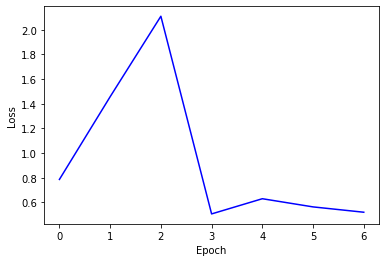

In [21]:
plt.plot(loss_plot, 'b')
# plt.plot(time_step_listener, 'g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.show()

In [34]:
def check_understanding(data):
    total_right = 0
    total_wrong = 0

    for (batch, (targ_tensor, dis_tensor)) in enumerate(data):
        hidden_s = speaker.reset_state(batch_size=targ_tensor.shape[0])
        hidden_l = listener.reset_state(batch_size=targ_tensor.shape[0])

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * targ_tensor.shape[0], 1)

        m = dec_input

        u = tf.concat([targ_tensor, dis_tensor], -1)

        #Encode the image through CNN
        features = encoder_s(u)

        #make sure that these are 256+256 = 512 and not 32+32 = 64
        for i in range(1,10):
            predictions, hidden, _ = speaker(dec_input, features, hidden_s)
            
            preds = tf.nn.softmax(predictions)
            indices = tf.math.argmax(predictions, axis=1)
            indices = tf.reshape(tf.cast(indices, tf.int32),(targ_tensor.shape[0],1))
            
            m = tf.concat([m, indices],1)

            dec_input = indices

        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ_tensor)
        features_d = encoder_l(dis_tensor)

        rand_n = random.random()

        left = features_t
        right = features_d

        v = listener(m, hidden_l)

        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))

        mask = tf.math.greater(x, y)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)

    total = total_right + total_wrong

    acc = total_right / total

    return acc, total_right, total_wrong

In [35]:
def map_func_test(img_name, img_name_2):
  img_tensor = np.load('../dataset/prep_data/'+img_name.decode('utf-8')+'.jpg.npy')
  img_tensor_2 = np.load('../dataset/prep_data/'+img_name_2.decode('utf-8')+'.jpg.npy')

  return img_tensor, img_tensor_2

In [36]:
testset = tf.data.Dataset.from_tensor_slices((targ_name_test, dis_name_test))
testset = testset.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset = testset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

with open("../dataset/easy_captions.json", "r") as jfec:
    easy_data = json.loads(jfec.read())

target_easy_data = easy_data['target_paths']
distractor_easy_data = easy_data['distractor_paths']

val_slice_index = int(len(target_easy_data)*0.8)
test_slice_index = int(len(target_easy_data)*0.9)

targ_easy_test = target_easy_data[test_slice_index:]

dis_easy_test = distractor_easy_data[test_slice_index:]

testset_easy = tf.data.Dataset.from_tensor_slices((targ_easy_test, dis_easy_test))
testset_easy = testset_easy.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset_easy = testset_easy.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [37]:
acc, tot_r, tot_w = check_understanding(testset)

In [38]:
print("Test Set Difficult")
print(acc, tot_r, tot_w)

Test Set Difficult
0.7218181818181818 1588 612


In [39]:
acc, tot_r, tot_w = check_understanding(testset_easy)
print("Test Set Easy")
print(acc, tot_r, tot_w)

Test Set Easy
0.8045454545454546 1770 430


In [55]:
print(len(target_data))
print(len(distractor_data))

22000
22000


In [28]:
with open('../human_evaluation/x.json', 'r') as jf:
    X = json.loads(jf.read())
# 

In [29]:
Y = np.random.choice(22000, 100)

[8087, 14553, 16441, 8106, 16283, 20433, 1002, 9493, 2354, 16094, 10280, 17108, 14591, 10682, 1586, 21613, 18953, 6906, 20811, 63, 19154, 12700, 13586, 687, 19465, 7543, 15422, 16364, 8896, 21512, 19437, 21019, 19436, 15750, 17656, 6914, 9437, 15950, 13581, 11742, 13667, 2431, 4930, 8648, 11637, 20426, 2856, 1171, 4598, 13786, 14159, 17844, 8749, 3639, 4501, 801, 15944, 3437, 2003, 15704, 3631, 3452, 16943, 3236, 15320, 15459, 12758, 16236, 16566, 12421, 2648, 13916, 1178, 19509, 7725, 5753, 15633, 13441, 8076, 2233, 19968, 8685, 20974, 11369, 11152, 11040, 14705, 6733, 15902, 7065, 8934, 1340, 3331, 5652, 12893, 5139, 3790, 13323, 2918, 10742]


In [33]:
correct = {}
for i in tqdm(range(len(Y))):
    curr_ind = Y[i]
    t = show_test(curr_ind, i)
    correct[i] = t

with open("../human_evaluation/mlt_0.1/correct.json", "w") as wj:
    json.dump(correct, wj)

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>